In [10]:
import math

import matplotlib.pyplot as plt
import pandas as pd

from notebooks.analytics.utils import init_analysis, savefig, set_save_folder

In [11]:
labels = {
    "test_acc": "Accuracy of cluster",
    "validation_acc": "Accuracy of trainers",
    "test_loss": "Loss of cluster",
    "validation_loss": "Loss of trainers",
    "round_id": "Rounds"
}


def comparison(exp_0, exp_1, dataset_description, problem_description, model):
    return {
        "exp": (exp_0, exp_1),
        "description": dataset_description,
        "problem": problem_description,
        "model": model
    }

COMPARABLE = [
    comparison(
        "fed_avg_01",
        "daeclust_10",
        "MNIST",
        "classification",
        "LeNet"
    ),
    comparison(
        "fed_avg_08",
        "daeclust_2000_05",
        "MNIST-FMNIST",
        "classification",
        "LeNet"
    ),
    #index 2
    comparison(
        "fed_avg_02",
        "daeclust_2000_07",
        "MNIST split by labels [0,3[, [3,6[, [6,9]",
        "classification",
        "LeNet"
    ),
    comparison(
        "fed_avg_05",
        "daeclust_09",
        "MNIST",
        "autoencoder",
        "CAELeNet"
    ),
    comparison(
        "fed_avg_10",
        "daeclust_11",
        "MNIST split by labels [0,3[, [3,6[, [6,9]",
        "autoencoder",
        "CAELeNet"
    ),
    # index 5
    comparison(
        "fed_avg_11",
        "daeclust_12",
        "MNIST-FMNIST",
        "autoencoder",
        "CAELeNet"
    ),
    # index 6
    comparison(
        "fed_avg_09",
        "daeclust_15",
        "MNIST-FMNIST",
        "classification",
        "LeNet Light"
    ),
    #index 7
    comparison(
        "fed_avg_13",
        "daeclust_16",
        "MNIST, normal distribution, 1 std",
        "classification",
        "LeNet"
    ),
    #index 8
    comparison(
        "fed_avg_13",
        "daeclust_16_01",
        "MNIST, normal distribution, 1 std, tol 3",
        "classification",
        "LeNet"
    ),
    #index 9
    comparison(
        "fed_avg_13",
        "daeclust_17_00",
        "MNIST, normal distribution, 1 std, tol 2",
        "classification",
        "LeNet"
    ),
    #index 10
    comparison(
        "fed_avg_13",
        "daeclust_18_00",
        "MNIST, normal distribution, 1 std, tol 1",
        "classification",
        "LeNet"
    )
]

COMPARE_INDEX = 0

meta_info = COMPARABLE[COMPARE_INDEX]

EXP_FED_AVG = meta_info.get("exp")[0]
EXP_DECLUST = meta_info.get("exp")[1]
(EXP_FED_AVG, EXP_DECLUST)

('fed_avg_01', 'daeclust_10')

In [12]:
fed_avg = init_analysis(EXP_FED_AVG)
declust = pd.concat([
    init_analysis(f"{EXP_DECLUST}-clusters"),
    init_analysis(f"{EXP_DECLUST}-clusters-selection")
])
set_save_folder("comparison")

In [13]:
declust_mean = declust.groupby(["round_id", "trainer_id"])["test_acc"].max().groupby("round_id").mean()
fed_avg_mean = fed_avg.groupby(["round_id"])["test_acc"].mean()

(declust_mean - fed_avg_mean) / fed_avg_mean

round_id
0.0           NaN
1.0      0.186624
2.0      0.057369
3.0      0.047796
4.0      0.039202
           ...   
98.0     0.011418
99.0     0.011468
100.0    0.010127
101.0    0.010588
102.0         NaN
Name: test_acc, Length: 103, dtype: float64

In [14]:
fed_avg.groupby(["round_id"])["test_acc"].min()

round_id
0.0           NaN
1.0      0.557034
2.0      0.702087
3.0      0.785171
4.0      0.825095
           ...   
98.0     0.954373
99.0     0.960076
100.0    0.967681
101.0    0.969639
102.0    0.961977
Name: test_acc, Length: 103, dtype: float64

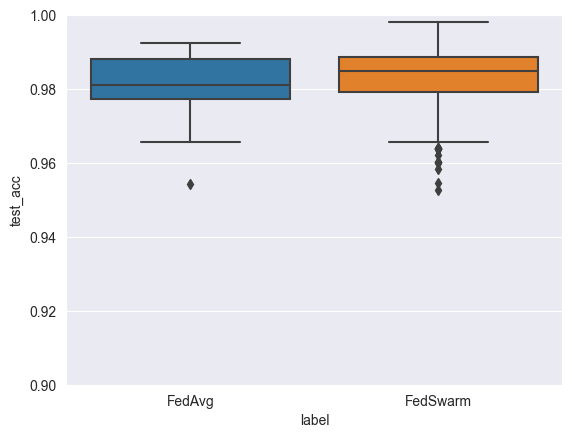

In [26]:
fed_avg["label"] = "FedAvg"
declust["label"] = "FedSwarm"

import seaborn as sns

merged = pd.concat([fed_avg, declust])
ax = sns.boxplot(merged.loc[merged.round_id == 98], x="label", y="test_acc")
ax.set(ylim=(0.9, 1))
plt.show()

In [34]:
fed_avg["test_acc"].loc[fed_avg.round_id == 101].min()

0.9696394801139832

In [35]:
declust["test_acc"].loc[declust.round_id == 101].min()

0.9430739879608154

C:\Users\micdu\AppData\Local\Temp\ipykernel_28208\2603175615.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\micdu\AppData\Local\Temp\ipykernel_28208\2603175615.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


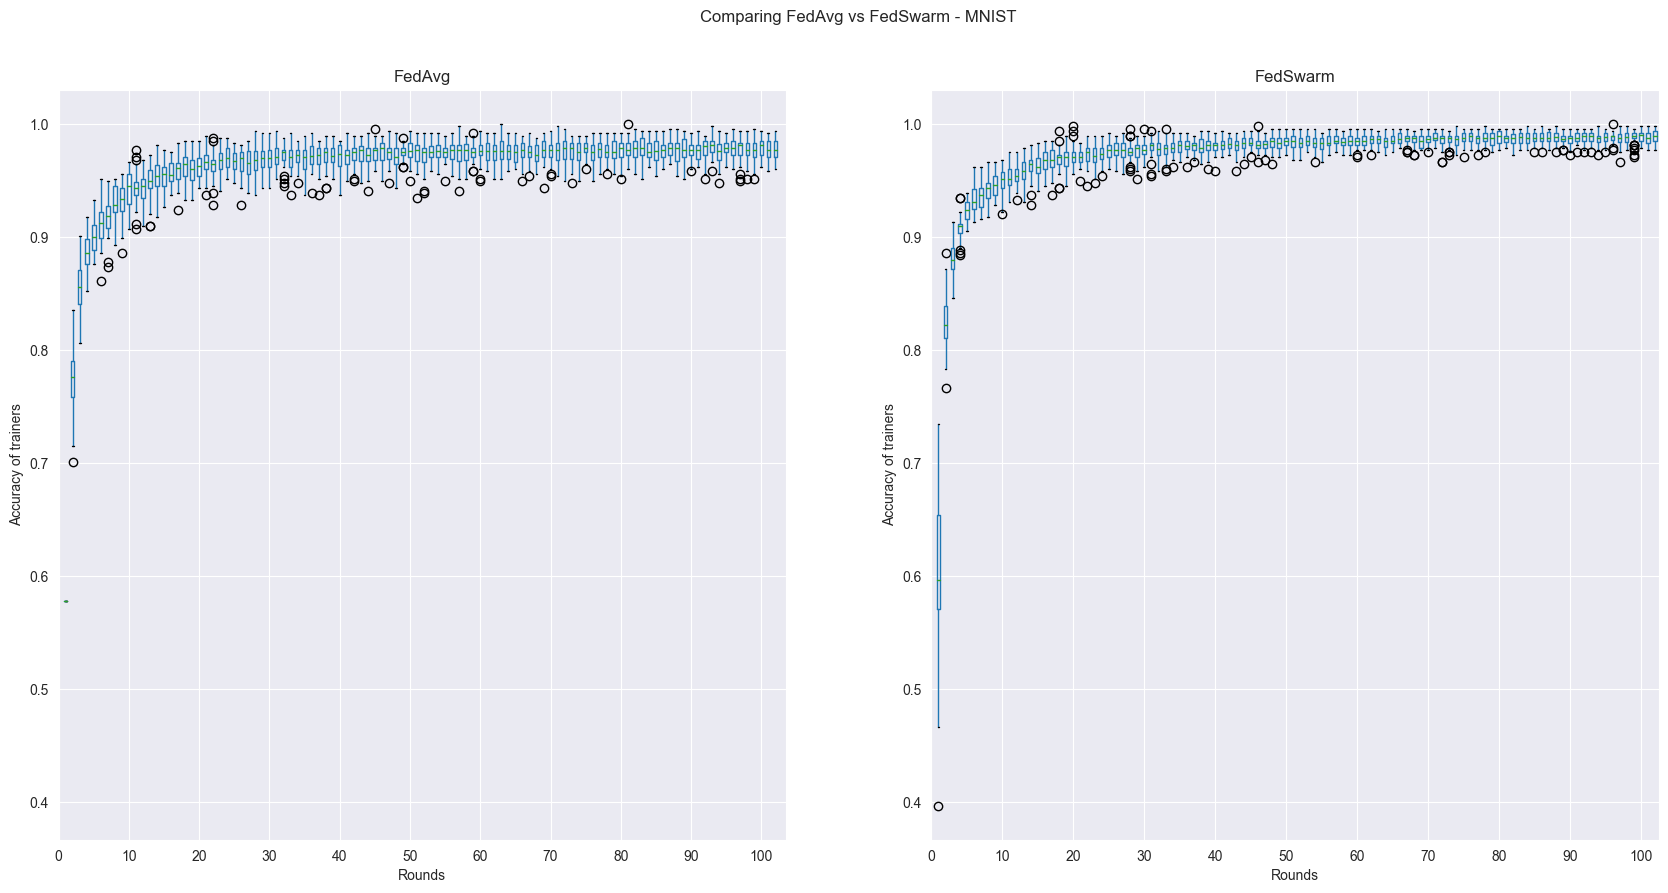

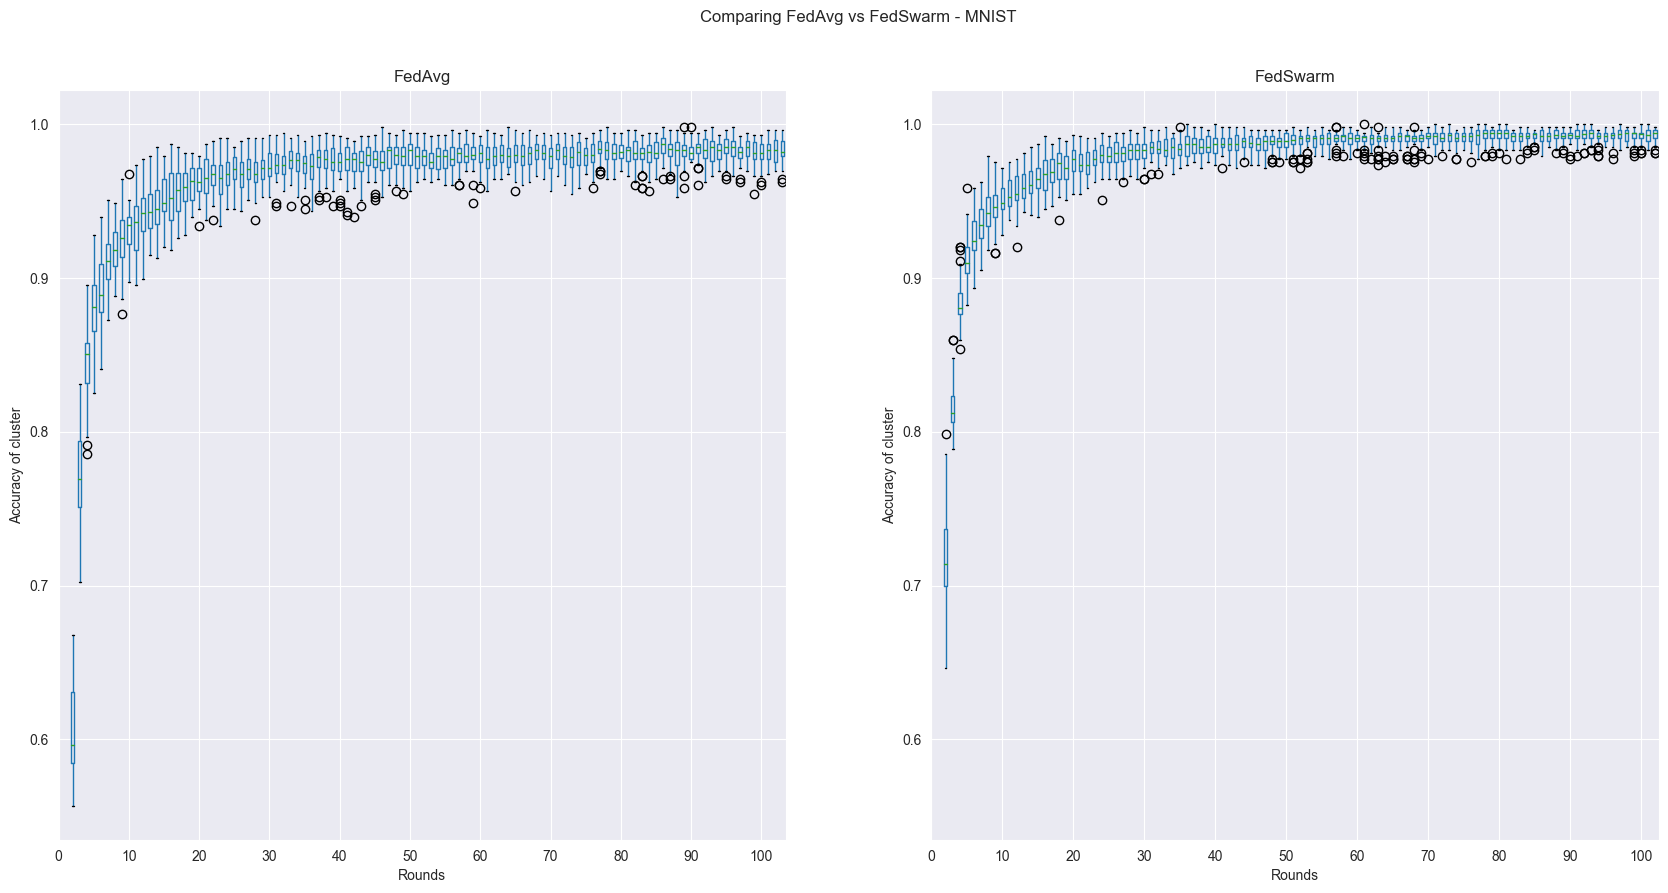

In [16]:
def boxplot_from_df(ax, df, column, xticks, title):
        plot_ax = df.boxplot(column, by="round_id", ax=ax)
        plot_ax.set_xticks(xticks, xticks)
        plot_ax.set_title(title)
        plot_ax.set_ylabel(labels.get(column))
        plot_ax.set_xlabel(labels.get("round_id"))
        return plot_ax

def compare(df_0, df_1, column, dataset=None):
    data_0 = df_0.reset_index()
    data_1 = df_1.reset_index()
    max_round = data_1.round_id.max()
    xticks = range(0, int(max_round), math.floor(max_round/10))
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 2, 1)
    title = "FedAvg" if dataset is None else f"FedAvg - {dataset}"
    boxplot_from_df(ax, data_0, column, xticks, title)
    ax = fig.add_subplot(1, 2, 2, sharey=ax)
    title = "FedSwarm" if dataset is None else f"FedSwarm - {dataset}"
    boxplot_from_df(ax, data_1, column, xticks, title)
    return fig

def plot_compare(metric, max=False, min=False):
    def groupby(df, dataset=None):
        if dataset:
            df = df.loc[df.dataset == dataset]
        df = df.groupby(["round_id", "trainer_id"])
        if (not max and not min) or max:
            df = df.max()
        elif min:
            df = df.min()
        return df

    datasets = fed_avg.dataset.unique()
    if len(datasets) > 1:
        for dataset in datasets:
            fig = compare(
                groupby(fed_avg, dataset),
                groupby(fed_avg, dataset),
                metric,
                dataset=dataset
            )
            fig.suptitle(f'Comparing FedAvg vs FedSwarm - {meta_info.get("description")}')
            savefig(fig, f"{dataset}-{metric}--{EXP_FED_AVG}--{EXP_DECLUST}")
            fig.show()
    else:
        fig = compare(
            groupby(fed_avg),
            groupby(declust),
            metric,
        )
        fig.suptitle(f'Comparing FedAvg vs FedSwarm - {meta_info.get("description")}')
        savefig(fig, f"{datasets[0]}-{metric}--{EXP_FED_AVG}--{EXP_DECLUST}")
        fig.show()

def plot_meta():
    if meta_info.get("problem") == "classification":
        plot_compare("validation_acc")
        plot_compare("test_acc")
    else:
        plot_compare("validation_loss", min=True)
        plot_compare("test_loss", min=True)

plot_meta()

In [17]:
import seaborn as sns
df_declust_mean = pd.DataFrame(declust_mean)
df_declust_mean["algo"] = "FedSwarm"
df_fed_avg_mean = pd.DataFrame(fed_avg_mean)
df_fed_avg_mean["algo"] = "FedAvg"
df_means = pd.concat([df_fed_avg_mean, df_declust_mean])
df_means

,test_acc,algo
round_id,,
0.0,NaN,FedAvg
1.0,0.606043,FedAvg
2.0,0.773100,FedAvg
3.0,0.844153,FedAvg
4.0,0.878653,FedAvg
...,...,...
97.0,0.992600,FedSwarm
98.0,0.992301,FedSwarm
99.0,0.992300,FedSwarm


<AxesSubplot: xlabel='round_id', ylabel='test_acc'>

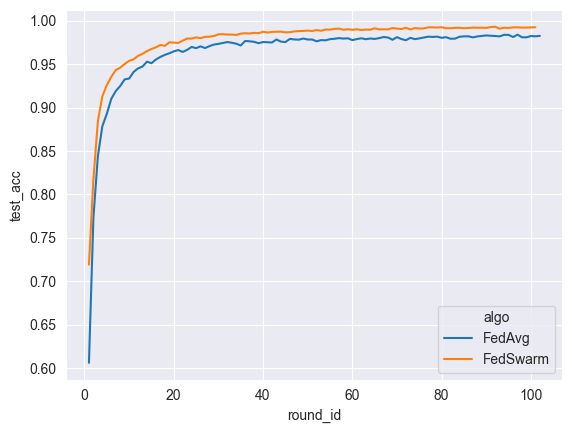

In [18]:
sns.lineplot(df_means.reset_index(),x="round_id", y="test_acc", hue="algo")